In [106]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [107]:
marketing = pd.read_csv('Cust_Records.csv')
marketing.columns

Index(['Age', 'Education', 'Relationship_Status', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)', 'Cust_Accept (%)'],
      dtype='object')

In [108]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 19 columns):
Age                    2227 non-null int64
Education              2227 non-null object
Relationship_Status    2227 non-null object
Income                 2227 non-null float64
Children               2227 non-null int64
Wine ($)               2227 non-null int64
Fruit ($)              2227 non-null int64
Meat ($)               2227 non-null int64
Fish ($)               2227 non-null int64
Sweets ($)             2227 non-null int64
Gold_Products ($)      2227 non-null int64
Discount_Purchases     2227 non-null int64
Web_Purchases          2227 non-null int64
Catalog_Purchases      2227 non-null int64
Store_Purchases        2227 non-null int64
Days_Enrolled          2227 non-null float64
Avg_Purch_Freq         2227 non-null float64
Avg_Spend ($)          2227 non-null float64
Cust_Accept (%)        2227 non-null float64
dtypes: float64(5), int64(12), object(2)
memory usage: 330.7+ KB

*Preprocessing for Customer Segmentation Below*

In [109]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

def box_cox_df(x):
    x_boxcox, _ = stats.boxcox(x)
    return(x_boxcox)

marketing_ml = marketing.drop('Cust_Accept (%)', axis=1)
### Numerically Encoding Categorical Features ###
categorical = pd.get_dummies(data=marketing_ml, columns=['Education', 'Relationship_Status'], drop_first=False)

### Unskewing Data with Box Cox ###
# numerical = marketing_ml[['Income', 'Children',
#        'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
#        'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases',
#        'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
#        'Avg_Purch_Freq', 'Avg_Spend ($)']]
# numerical = numerical.apply(box_cox_df, axis=0)

### Scaling Numerical Features ###
# scaler = StandardScaler()
# numerical = scaler.fit_transform(marketing_ml[['Income', 'Children',
#        'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
#        'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases',
#        'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
#        'Avg_Purch_Freq', 'Avg_Spend ($)']])
# numerical = pd.DataFrame(numerical, columns=['Income', 'Children',
#        'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
#        'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases',
#        'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
#        'Avg_Purch_Freq', 'Avg_Spend ($)'])
### Bring Categorical and Numerical Together ###
# marketing_ml = categorical.merge(right=numerical, how='right')
print(categorical.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 26 columns):
Age                                    2227 non-null int64
Income                                 2227 non-null float64
Children                               2227 non-null int64
Wine ($)                               2227 non-null int64
Fruit ($)                              2227 non-null int64
Meat ($)                               2227 non-null int64
Fish ($)                               2227 non-null int64
Sweets ($)                             2227 non-null int64
Gold_Products ($)                      2227 non-null int64
Discount_Purchases                     2227 non-null int64
Web_Purchases                          2227 non-null int64
Catalog_Purchases                      2227 non-null int64
Store_Purchases                        2227 non-null int64
Days_Enrolled                          2227 non-null float64
Avg_Purch_Freq                         2227 non-null float64
Av

Text(0.5, 1.0, 'Elbow Plot')

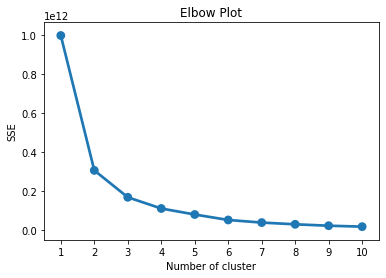

In [110]:
from sklearn.cluster import KMeans
import seaborn as sns

X = categorical
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=27)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title('Elbow Plot')

In [111]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(X)
labels = kmeans.labels_
marketing['Cluster'] = labels
print('Cluster Counts')
print(marketing['Cluster'].value_counts())
education = marketing.groupby(['Cluster', 'Education'])['Education'].count()
print('\nPercentage of Cluster Totals by Education')
print(round((education / education.groupby(level=0).sum()) * 100))
relationship = marketing.groupby(['Cluster', 'Relationship_Status'])['Education'].count()
print('\nPercentage of Cluster Totals by Relationship Status')
print(round((relationship / relationship.groupby(level=0).sum()) * 100))
marketing.groupby('Cluster').mean()

Cluster Counts
0    800
1    744
2    683
Name: Cluster, dtype: int64

Percentage of Cluster Totals by Education
Cluster  Education 
0        2n Cycle       8.0
         Graduation    48.0
         Master        19.0
         PhD           25.0
1        2n Cycle      11.0
         Basic          7.0
         Graduation    51.0
         Master        15.0
         PhD           16.0
2        2n Cycle       8.0
         Graduation    53.0
         Master        15.0
         PhD           24.0
Name: Education, dtype: float64

Percentage of Cluster Totals by Relationship Status
Cluster  Relationship_Status
0        Divorced               12.0
         In-Relationship        26.0
         Married                37.0
         Single                 21.0
         Widow                   4.0
1        Divorced                9.0
         In-Relationship        26.0
         Married                40.0
         Single                 24.0
         Widow                   2.0
2        Divorced  

,Age,Income,Children,Wine ($),Fruit ($),Meat ($),Fish ($),Sweets ($),Gold_Products ($),Discount_Purchases,Web_Purchases,Catalog_Purchases,Store_Purchases,Days_Enrolled,Avg_Purch_Freq,Avg_Spend ($),Cust_Accept (%)
Cluster,,,,,,,,,,,,,,,,,
0,47.862500,52465.656778,1.227500,291.192500,19.146250,99.583750,25.372500,18.390000,46.331250,3.103750,4.761250,2.266250,6.077500,474.195000,37.569836,26.654788,5.000000
1,40.853495,28499.263441,1.126344,31.221774,6.005376,25.755376,9.083333,6.087366,17.766129,2.153226,2.169355,0.530914,3.098118,483.673387,73.362528,10.369226,3.449821
2,46.433382,76739.800878,0.437775,617.834553,56.926794,398.846266,83.083455,60.412884,70.165447,1.614934,5.414348,5.469985,8.431918,471.620791,24.721003,63.729498,14.690093


*Regression to Predict Cust_Accept (%)*

In [112]:
### Random Forest Regressor, HyperParameter Tuning ###
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
X = categorical.values
y = marketing['Cust_Accept (%)'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
rfr = RandomForestRegressor(n_jobs=-1, oob_score=True)
grid_search = GridSearchCV(rfr, 
                           param_grid={
                                       "n_estimators": [100, 200, 600, 1000],
                                       "min_samples_leaf": [5, 3, 2, 1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1,
                           cv=5,
                           iid=False, # just return the average score across folds
                           return_train_score=False, scoring = 'r2')
grid_search.fit(X_train, y_train)
y_pred_test = grid_search.predict(X_test)
best_rfr = grid_search.best_estimator_


 *Most Important Education Category*
                 cols      imp
 Education_Graduation  0.00964

 *Most Important Relationship_Status Category*
                        cols       imp
 Relationship_Status_Married  0.006945

 *Most Important Purchases Category*
              cols       imp
 Catalog_Purchases  0.051836

 *Most Important ($) Category*
     cols       imp
 Wine ($)  0.177836


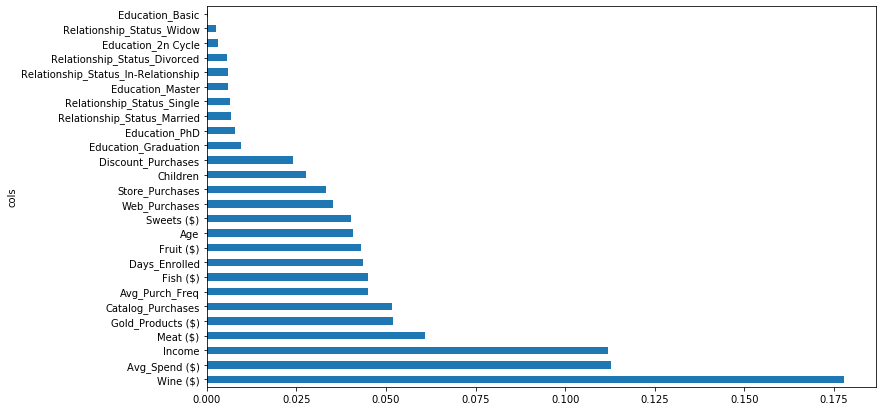


OOB Score:  0.42087160493827114

Best Params: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}

Testing RMSE: 10.427190973117655

Testing R2:  0.42650685720762427


In [116]:
### Analyzing Performance & Feature Importance Towards Cust Accept % ###

from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV


def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

fi = rf_feat_importance(best_rfr, categorical)
for feature in ['Education', 'Relationship_Status', 'Purchases', '($)']:
    print('\n', '*Most Important', feature, 'Category*' )
    new = fi.loc[fi['cols'].str.contains(feature)]
    print(new.sort_values('imp', ascending=False).head(1).to_string(index=False))

plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_rfr.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('\nTesting RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('\nTesting R2: ', grid_search.score(X_test, y_test))